# Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
rating_small = pd.read_csv('/content/drive/My Drive/PY/RecSys/ratings.csv')
# ratings = pd.read_csv('ml-latest/ratings.csv')    
train, test = train_test_split(rating_small, test_size=0.2)
print (train.head(20)) 

       userId  movieId  rating   timestamp
99946     610     6156     3.5  1479542300
39986     274     5463     2.5  1171828131
81675     517     2018     4.0  1487953729
49801     318   127172     3.5  1422789148
90532     590      111     4.0  1260379976
55729     368     2802     3.0   971276831
3717       22     6870     4.0  1268726636
20289     133      524     3.0   843491580
89879     583     6619     3.0  1481474550
84792     550    86332     4.0  1488728409
36467     249     1265     4.5  1410392531
40843     275     3384     5.0  1049079320
48018     312        6     4.0  1043177752
72783     469     2640     3.0   965334150
26163     182      348     4.0  1055151865
84941     552      329     3.5  1111473082
43458     290     3741     4.0   974938036
92932     599      836     2.0  1519237962
32919     224      377     4.0   971812827
9830       64     5669     3.5  1161520420


In [ ]:
userMovie = pd.DataFrame(train.groupby('userId').apply(lambda x: dict(zip(x['movieId'],x['rating']))).reset_index(name='userMovieId'))
userMovie['itemCount'] = [len(i) for i in userMovie['userMovieId']]
userMovie = userMovie.set_index('userId')
userMovie.head()

,userMovieId,itemCount
userId,,
1,"{2046: 4.0, 1023: 5.0, 2987: 5.0, 2048: 5.0, 3...",187
2,"{109487: 3.0, 46970: 4.0, 106782: 5.0, 122882:...",28
3,"{1371: 3.0, 849: 5.0, 5764: 4.5, 527: 0.5, 201...",27
4,"{4967: 5.0, 4166: 3.0, 4896: 4.0, 1094: 3.0, 4...",177
5,"{364: 3.0, 590: 5.0, 50: 4.0, 266: 1.0, 1: 4.0...",35


132.24262295081968 57.0
603 (610, 2)


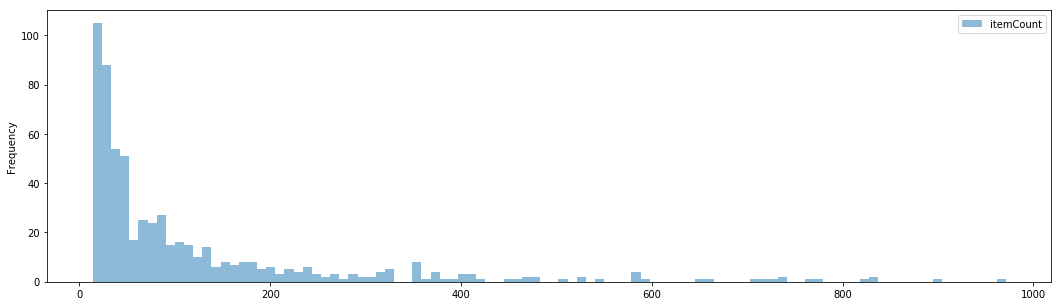

In [ ]:
print(userMovie["itemCount"].mean(), userMovie["itemCount"].median())
print(len(userMovie[userMovie["itemCount"]<1000]),userMovie.shape)
# 多数用户看过 20，30部左右电影，用户观看差异量大, >1000部的可能是outlier, 3200人左右
userMovie[userMovie["itemCount"]<1000].plot.hist(bins=100,alpha=0.5,figsize=(18,5))

In [ ]:
#test
import time
startTime = time.time() 

takeTimes = time.time() - startTime
print(takeTimes)

0.0


# Find Similar Users

In [ ]:
#通过用户ID获取用户的rating，返回字典
def getMovieRates(userId):
    if userId in userMovie.index:
        return userMovie.loc[userId][0]
    else:
        print('user ID not found')

#计算目标用户和对比用户间，相同观影记录以及rating差异，返回每部电影评分差异的list
def calcDistance(userId1, userId2):
    userMovie1 = getMovieRates(userId1)
    userMovie2 = getMovieRates(userId2)
#2用户打分差异值的绝对值，经过1/(1+x)倒数变换, 大值代表高相似， 这样可以把完全一样差异值为0的item对算进来
    diffSum = [round(1/(1+abs(userMovie1[k]-userMovie2[k])),2) for k in userMovie1 if k in userMovie2]
# ！！！    diffEuc = 1/(1+np.sqrt(np.sum(np.power(diffSum, 2)))) # Euc距离不准确 不使用！！
    if len(diffSum)>0:
        return diffSum
    else:
        return []

In [ ]:
#寻找与目标用户相似的用户
# 是选择有少量非常相似评分的用户，还是有大量比较相似的用户？？
def findSimUsers(targetUser, sameItemsRate=0.1, simLimit=0.7):
    simUsers = {}
    for i in userMovie.index:
        if i != targetUser:
            dis = calcDistance(targetUser, i)
    #共同的item数 要大于两个user总共items数平均值的n% - 过滤掉打分稀少 和 item密集用户，最为精确，只寻找item数量相似的用户
    #但是此阈值可能超过用户评分数的长度，所以应该限制大小为评分数少的那个用户的itemCount,in such case，该用户评分为另一用户的子集
    
            SimThreshold = round(sameItemsRate * np.mean(userMovie['itemCount'][[targetUser, i]])) 
            minSimThreshold =  np.min(userMovie['itemCount'][[targetUser, i]])
            if SimThreshold > minSimThreshold: 
                SimThreshold = minSimThreshold  #并不能解决对比用户为密集打分的情况，对面的多数据会影响到多数推荐
    #         SimThreshold = round(sameItemsRate * userMovie['itemCount'][i]) #共同的item数 要大于对比user总共items数的10% - 保留打分稀疏用户
#             SimThreshold = round(sameItemsRate * userMovie['itemCount'][targetUser]) #共同的item数 要大于目标user（自己）总共items数的n% - 数据量最多
            sameItems = len(dis) # 两用户都有评分的item
            if sameItems > SimThreshold:
            # 传统做法是判断多少个大于阈值的项目，然后决定是否是相关用户，然而有些密集打分用户会有很多相似项目，下面通过均分阈值继续判断
            #对所有相同项的评分差异值求平均，过滤掉有很多相同item的密集打分用户的影响
                sim = round(np.mean(dis),2)
                if sim > simLimit:  #simLimit = 0.7 对应 1/(1+dis) , 相当于过滤出平均分差0.42之内的用户
#                     print(i, sim, dis, userMovie['itemCount'][i])
                    simUsers[i] = sim
    return simUsers
simUsers = findSimUsers(2)

In [ ]:
simUsers

{65: 0.71, 88: 0.8, 189: 0.84, 378: 0.72, 400: 0.88, 548: 0.78}

# Recommend Movies

In [ ]:
# 是推荐最相似的那些用户的高评分item，还是大部分相似用户的平均高评分作品??
#这里只考虑前文选择的用户（>0.7）没有继续再考虑用户的相似度问题了
#可以使用用户的相似度作为rating的加权
#也可以不计算raitng，直接把评分二分类，对于好评电影统计count数来做topN推荐
# simUsers = findSimUsers(1)
userMovieSub = userMovie.loc[simUsers.keys(), ['userMovieId']] #选出的相似用户的评分
userMovieSub.head()

,userMovieId
userId,
65,"{109487: 4.5, 2959: 4.5, 33660: 4.0, 4993: 3.5..."
88,"{8665: 4.5, 16: 4.5, 785: 4.0, 54286: 4.5, 487..."
189,"{79132: 4.5, 76093: 4.0, 527: 4.5, 2762: 4.0, ..."
378,"{858: 3.0, 99114: 3.0, 44191: 4.0, 527: 4.5, 5..."
400,"{44199: 5.0, 44665: 4.0, 1213: 4.5, 48516: 4.0..."


In [ ]:
recMovie = {}
recMovieWeighted = {}
#只对相似用户的评分求平均，会受到部分口味清奇用户的评分影响，且忽略了多个相似用户看过同一部item的情况
for u in userMovieSub.index:
    ratings = userMovieSub.loc[u,'userMovieId']
    for i in ratings:
        if i in recMovie:
            recMovie[i].append(ratings[i])
            recMovieWeighted[i].append(ratings[i] * simUsers[u]) #sim-user weighted
        else:
            recMovie[i] = [ratings[i]]
            recMovieWeighted[i] = [ratings[i] * simUsers[u]] #sim-user weighted

for i in recMovie:
    recMovie[i] =  [len(recMovie[i]), round(np.mean(recMovie[i]),2), round(np.mean(recMovieWeighted[i]),2)] #长度，平均，加权平均

recMovies = pd.DataFrame(sorted(recMovie.items(), key=lambda a: np.mean(a[1][2]), reverse=True), columns=['recMovieId','rating'])
# recMovies['meanRating'] = round(recMovies['meanRating'],2)
recMovies['count'] = recMovies['rating'].map(lambda x:x[0])
recMovies['meanRating'] = recMovies['rating'].map(lambda x:x[1])
recMovies['weightedMeanRating'] = recMovies['rating'].map(lambda x:x[2])
del recMovies['rating']
recMovies

,recMovieId,count,meanRating,weightedMeanRating
0,44199,1,5.00,4.40
1,47,1,5.00,4.40
2,6,1,5.00,4.40
3,778,1,5.00,4.40
4,293,1,5.00,4.40
5,608,1,5.00,4.40
6,50,2,5.00,4.20
7,2571,2,5.00,4.15
8,1884,1,5.00,4.00
9,122886,1,4.50,3.96


In [ ]:
recMovieIds = list(recMovies[(recMovies['weightedMeanRating']>3)&(recMovies['count']>1)]['recMovieId'])
orig =  getMovieRates(2)
for i in orig:
  if i in recMovieIds:  
    recMovieIds.remove(i)  #去除目标用户已看过的
res_new = recMovies[recMovies['recMovieId'].isin(recMovieIds)] # 用户没看过的(没在训练集里的，有可能在测试集中)
# recMovies[(recMovies['weightedMeanRating']>3)&(recMovies['count']>1)&(recMovies['recMovieId'].isin([50,2571]))]
res_train = recMovies[recMovies['recMovieId'].isin(orig)].sort_values(by='recMovieId') #被推荐用户本来已经看过的，通过CF算出的得分，这个看做在训练集上的预测score

In [ ]:
def rateMAE(res, orig):
  res_rate =  dict(zip(res['recMovieId'],res['meanRating']))
  diff = []
  for i in res_rate:
    if i in orig:
  #     print(i,res_rate[i],orig[i])
      diff.append(abs(res_rate[i]-orig[i]))
  MAE = np.mean(diff)
  print('MAE:',MAE)
rateMAE(recMovies, orig)

MAE: 0.5064285714285715


In [ ]:
rateMAE(res_train, orig)

MAE: 0.5064285714285715


In [ ]:
res_test = test[test['userId']==2]
res_test_rate = dict(zip(res_test['userId'], res_test['rating']))
res_test_rate 

{2: 3.0}

In [ ]:
rateMAE(res_new, res_test_rate) #数据太少无法测试

MAE: nan


/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
movies = pd.read_csv('movies.csv') 
movies.head(5)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
recRes = pd.merge(recMovies, movies, how='inner',left_on='recMovieId' ,right_on='movieId').set_index('recMovieId')
recRes.loc[[1449,2134,3424,3893,89745,2010,33794]]

,count,meanRating,weightedMeanRating,movieId,title,genres
recMovieId,,,,,,
1449,15,4.27,3.49,1449,Waiting for Guffman (1996),Comedy
2134,11,4.27,3.31,2134,Weird Science (1985),Comedy|Fantasy|Sci-Fi
3424,22,4.30,3.34,3424,Do the Right Thing (1989),Drama
3893,6,3.75,2.93,3893,Nurse Betty (2000),Comedy|Crime|Drama|Romance|Thriller
89745,1,5.00,4.00,89745,"Avengers, The (2012)",Action|Adventure|Sci-Fi|IMAX
2010,2,4.75,4.26,2010,Metropolis (1927),Drama|Sci-Fi
33794,2,4.75,4.25,33794,Batman Begins (2005),Action|Crime|IMAX


In [ ]:
getMovieRates(1)
#因为没有去重，可以通过对比推荐的和用户真的看过的来对比 train_set score

{307: 3.5,
 481: 3.5,
 1091: 1.5,
 1257: 4.5,
 1449: 4.5,
 1590: 2.5,
 1591: 1.5,
 2134: 4.5,
 2478: 4.0,
 2840: 3.0,
 2986: 2.5,
 3020: 4.0,
 3424: 4.5,
 3698: 3.5,
 3826: 2.0,
 3893: 3.5}